In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2022-09-05 12:33:57--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.15.112, 142.250.81.208, 172.217.13.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.15.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   331MB/s    in 0.5s    

2022-09-05 12:33:57 (331 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
!unzip 10_food_classes_10_percent.zip

Archive:  10_food_classes_10_percent.zip
   creating: 10_food_classes_10_percent/
  inflating: __MACOSX/._10_food_classes_10_percent  
   creating: 10_food_classes_10_percent/test/
  inflating: __MACOSX/10_food_classes_10_percent/._test  
   creating: 10_food_classes_10_percent/train/
  inflating: __MACOSX/10_food_classes_10_percent/._train  
   creating: 10_food_classes_10_percent/test/ice_cream/
  inflating: __MACOSX/10_food_classes_10_percent/test/._ice_cream  
   creating: 10_food_classes_10_percent/test/chicken_curry/
  inflating: __MACOSX/10_food_classes_10_percent/test/._chicken_curry  
   creating: 10_food_classes_10_percent/test/steak/
  inflating: __MACOSX/10_food_classes_10_percent/test/._steak  
   creating: 10_food_classes_10_percent/test/sushi/
  inflating: __MACOSX/10_food_classes_10_percent/test/._sushi  
   creating: 10_food_classes_10_percent/test/chicken_wings/
  inflating: __MACOSX/10_food_classes_10_percent/test/._chicken_wings  
   creating: 10_food_classes_10_per

In [4]:
import os
import random

In [5]:
# Walk through data directory and list number of files
for dirpath, dirnames, filenames in os.walk("/content/10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '/content/10_food_classes_10_percent'.
There are 10 directories and 0 images in '/content/10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '/content/10_food_classes_10_perc

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
IMAGE_SHAPE=(224,224)
BATCH_SIZE=32
EPOCHS=5

train_dir="10_food_classes_10_percent/train/"
test_dir="10_food_classes_10_percent/test/"

train_datagen=ImageDataGenerator(rescale=1/255.)
test_datagen=ImageDataGenerator(rescale=1/255.)



train_data=train_datagen.flow_from_directory(train_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode='categorical')
test_data=test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode='categorical')

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [8]:
import datetime

def create_tensorboad_callback(dir_name,expriment_name):
  log_dir=dir_name + "/" +expriment_name + "/" +datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboad_callback=tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f'Save tensorboard log file to {log_dir}')
  return tensorboad_callback

In [9]:
resnet_url="https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

In [10]:
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"


In [11]:
import tensorflow_hub as hub
from tensorflow.keras import (layers,Sequential)
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam


In [12]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
  ])

  return model

In [13]:
# Create resnet model
resnet_model= create_model(resnet_url,
                           num_classes=train_data.num_classes)

In [14]:
# Compile
resnet_model.compile(loss='CategoricalCrossentropy',
                     optimizer=Adam(),
                     metrics=["accuracy"])

In [15]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [16]:
# Fit the model
resnet_history = resnet_model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboad_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         expriment_name="resnet50V2")]) # name of log files

Save tensorboard log file to tensorflow_hub/resnet50V2/20220905-123409
Epoch 1/5
24/24 [==============================] - 36s 754ms/step - loss: 1.7744 - accuracy: 0.4107 - val_loss: 1.1550 - val_accuracy: 0.6276
Epoch 2/5
24/24 [==============================] - 16s 673ms/step - loss: 0.8625 - accuracy: 0.7400 - val_loss: 0.8473 - val_accuracy: 0.7264
Epoch 3/5
24/24 [==============================] - 16s 673ms/step - loss: 0.5932 - accuracy: 0.8293 - val_loss: 0.7468 - val_accuracy: 0.7640
Epoch 4/5
24/24 [==============================] - 17s 741ms/step - loss: 0.4616 - accuracy: 0.8800 - val_loss: 0.6992 - val_accuracy: 0.7752
Epoch 5/5
24/24 [==============================] - 16s 666ms/step - loss: 0.3632 - accuracy: 0.9160 - val_loss: 0.6786 - val_accuracy: 0.7848


In [17]:
# If you wanted to, you could really turn this into a helper function to load in with a helper.py script...
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

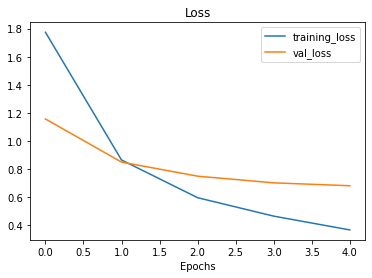

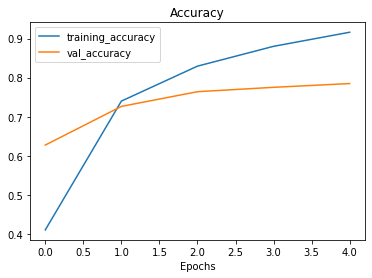

In [18]:
plot_loss_curves(resnet_history)

This is overfit when loss train going loss down but val loss goin rise 

## Create efficient net

In [19]:
train_data.num_classes

10

In [20]:
efficient_net_model=create_model(model_url=efficientnet_url,
                                 num_classes=train_data.num_classes)

# Compile model
efficient_net_model.compile(loss='CategoricalCrossentropy',
                     optimizer=Adam(),
                     metrics=["accuracy"])

# Fit model efficient net 
efficient_hist=efficient_net_model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboad_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         expriment_name="efficientnet")]) # name of log files

Save tensorboard log file to tensorflow_hub/efficientnet/20220905-123611
Epoch 1/5
24/24 [==============================] - 26s 715ms/step - loss: 1.8566 - accuracy: 0.4347 - val_loss: 1.2985 - val_accuracy: 0.7348
Epoch 2/5
24/24 [==============================] - 24s 1s/step - loss: 1.0524 - accuracy: 0.7907 - val_loss: 0.8626 - val_accuracy: 0.8196
Epoch 3/5
24/24 [==============================] - 15s 644ms/step - loss: 0.7500 - accuracy: 0.8347 - val_loss: 0.6909 - val_accuracy: 0.8416
Epoch 4/5
24/24 [==============================] - 15s 648ms/step - loss: 0.6005 - accuracy: 0.8653 - val_loss: 0.6051 - val_accuracy: 0.8588
Epoch 5/5
24/24 [==============================] - 16s 688ms/step - loss: 0.5065 - accuracy: 0.8947 - val_loss: 0.5552 - val_accuracy: 0.8608


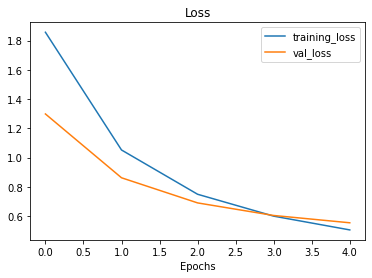

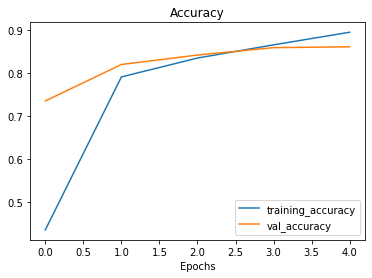

In [21]:
plot_loss_curves(efficient_hist)

its only use 10% data but accuracy high and not get overfitt or underfitt

In [22]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [23]:
efficient_net_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [24]:
# Check how many layers does in model efficient net feature extractor have
len(efficient_net_model.layers[0].weights)

309

so **"efficient net"** have 309 layers

In [25]:
efficient_net_model.layers[0].weights

[<tf.Variable 'stem_conv2d/kernel:0' shape=(3, 3, 3, 32) dtype=float32, numpy=
 array([[[[ 2.07668245e-02,  8.53624821e-01, -9.72171009e-01,
            5.80005467e-01,  3.13335508e-02, -1.81043148e-02,
           -1.28635168e-02,  5.94060645e-02, -7.41896749e-01,
           -2.27897346e-01,  2.00766921e-01, -2.33019665e-02,
           -3.82314444e-01, -1.13366711e+00, -4.97356057e-02,
           -5.28575480e-01,  6.01686649e-02,  3.28413874e-01,
            7.26403654e-01,  9.56093222e-02,  2.53003836e-03,
            7.99428642e-01,  1.60467178e-01,  1.51992925e-02,
            2.15564728e-01, -6.15406692e-01,  7.56446272e-02,
            3.47692966e-02,  0.00000000e+00, -6.27994761e-02,
            2.23197415e-02, -1.42137900e-01],
          [ 1.28902495e-02,  1.56575632e+00, -1.80467033e+00,
            7.77730107e-01,  6.52952865e-02,  2.08790317e-01,
           -8.81190374e-02, -3.78276139e-01,  5.80090940e-01,
           -3.44047934e-01,  6.91463649e-02, -8.79267603e-02,
       

In [26]:
resnet_model.layers[0].weights

[<tf.Variable 'resnet_v2_50/block2/unit_1/bottleneck_v2/shortcut/biases:0' shape=(512,) dtype=float32, numpy=
 array([ 4.31418499e-07,  4.89472598e-07,  2.27145790e-07, -8.81433607e-07,
        -4.73612602e-07, -5.08580285e-07,  2.22534609e-07, -2.61754479e-07,
        -5.20312483e-07,  5.15780016e-07,  6.28244322e-07, -1.23574966e-06,
        -2.06205897e-07, -5.50552784e-07,  4.59568270e-07,  1.22070418e-07,
         1.27279168e-06,  2.39852739e-07, -1.79164545e-06,  5.12351086e-08,
         2.51728920e-06,  7.22962625e-07,  1.10817304e-07, -1.69962846e-06,
        -3.23063404e-07, -9.74833142e-07,  1.12322664e-06,  4.19217031e-07,
         7.60933744e-07, -5.42234204e-07,  1.20253515e-06,  1.10281167e-06,
        -3.48003937e-07, -7.72205851e-07,  1.68280877e-07, -3.24905358e-07,
        -1.27801570e-06,  1.57823706e-06,  6.09036192e-07,  1.57570196e-06,
         1.42022566e-06,  7.20819116e-07,  5.48808785e-08,  4.61077349e-07,
         1.15990485e-06,  4.04862874e-07, -5.38943368e

In [27]:
len(resnet_model.layers[0].weights)

270

so **"Res net"** have 309 layers

## 🛠 Exercises

1. Build and fit a model using the same data we have here but with the MobileNetV2 architecture feature extraction ([`mobilenet_v2_100_224/feature_vector`](https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4)) from TensorFlow Hub, how does it perform compared to our other models?
2. Name 3 different image classification models on TensorFlow Hub that we haven't used.
3. Build a model to classify images of two different things you've taken photos of.
  * You can use any feature extraction layer from TensorFlow Hub you like for this.
  * You should aim to have at least 10 images of each class, for example to build a fridge versus oven classifier, you'll want 10 images of fridges and 10 images of ovens.
4. What is the current best performing model on ImageNet?
  * Hint: you might want to check [sotabench.com](https://www.sotabench.com) for this.

# Number 1

In [28]:
mobileNet_url="https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"

In [29]:
# Create mobileNet
mobileNet_model=create_model(model_url=mobileNet_url,
                                 num_classes=train_data.num_classes)

In [30]:
# Compile mobileNet
mobileNet_model.compile(loss="CategoricalCrossentropy",
                                       optimizer=Adam(),
                                       metrics=["accuracy"])

In [31]:
hist_mobileNet=mobileNet_model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboad_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         expriment_name="mobileNet")]) # name of log files)

Save tensorboard log file to tensorflow_hub/mobileNet/20220905-123751
Epoch 1/5
24/24 [==============================] - 19s 661ms/step - loss: 2.0255 - accuracy: 0.3040 - val_loss: 1.3445 - val_accuracy: 0.5900
Epoch 2/5
24/24 [==============================] - 15s 630ms/step - loss: 1.0602 - accuracy: 0.7000 - val_loss: 0.9058 - val_accuracy: 0.7432
Epoch 3/5
24/24 [==============================] - 15s 629ms/step - loss: 0.7537 - accuracy: 0.8000 - val_loss: 0.7530 - val_accuracy: 0.7840
Epoch 4/5
24/24 [==============================] - 15s 633ms/step - loss: 0.5910 - accuracy: 0.8533 - val_loss: 0.6926 - val_accuracy: 0.7908
Epoch 5/5
24/24 [==============================] - 15s 631ms/step - loss: 0.4884 - accuracy: 0.8773 - val_loss: 0.6472 - val_accuracy: 0.7992


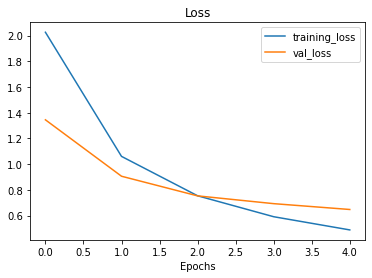

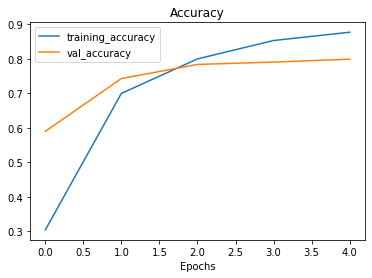

In [32]:
plot_loss_curves(hist_mobileNet)

In [33]:
pd.DataFrame(hist_mobileNet.history)

,loss,accuracy,val_loss,val_accuracy
0,2.025461,0.304000,1.344520,0.5900
1,1.060166,0.700000,0.905797,0.7432
2,0.753747,0.800000,0.753019,0.7840
3,0.590974,0.853333,0.692586,0.7908
4,0.488374,0.877333,0.647229,0.7992


## Evalution

https://stackoverflow.com/questions/50825936/confusion-matrix-on-images-in-cnn-keras

In [34]:
preds = mobileNet_model.predict(test_data,
verbose=1)

79/79 [==============================] - 12s 146ms/step


In [35]:
predicted_classes = tf.argmax(preds, axis=1)

In [36]:
true_classes = test_data.classes


In [37]:
class_labels=test_data.class_indices

In [38]:
class_labels=list(class_labels)

In [39]:
from sklearn.metrics import (classification_report,confusion_matrix,ConfusionMatrixDisplay)

In [40]:
cm = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(cm)  

                precision    recall  f1-score   support

 chicken_curry       0.07      0.07      0.07       250
 chicken_wings       0.09      0.08      0.09       250
    fried_rice       0.11      0.11      0.11       250
grilled_salmon       0.10      0.13      0.11       250
     hamburger       0.11      0.11      0.11       250
     ice_cream       0.11      0.10      0.11       250
         pizza       0.10      0.10      0.10       250
         ramen       0.06      0.06      0.06       250
         steak       0.08      0.08      0.08       250
         sushi       0.09      0.08      0.08       250

      accuracy                           0.09      2500
     macro avg       0.09      0.09      0.09      2500
  weighted avg       0.09      0.09      0.09      2500



In [41]:
class_labels

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [42]:
import seaborn as sns

heatmap : https://stackoverflow.com/questions/69900954/when-creating-a-seaborn-heatmap-could-not-convert-string-to-float-valueerror

reference  colors: https://matplotlib.org/stable/tutorials/colors/colormaps.html#grayscale-conversion <br>
https://github.com/scikit-learn/scikit-learn/blob/36958fb240fbe435673a9e3c52e769f01f36bec0/sklearn/metrics/_plot/confusion_matrix.py#L151

In [43]:
import itertools

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(15, 15), text_size=12): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
             horizontalalignment="center",
             color="white" if cm[i, j] > threshold else "black",
             size=text_size)

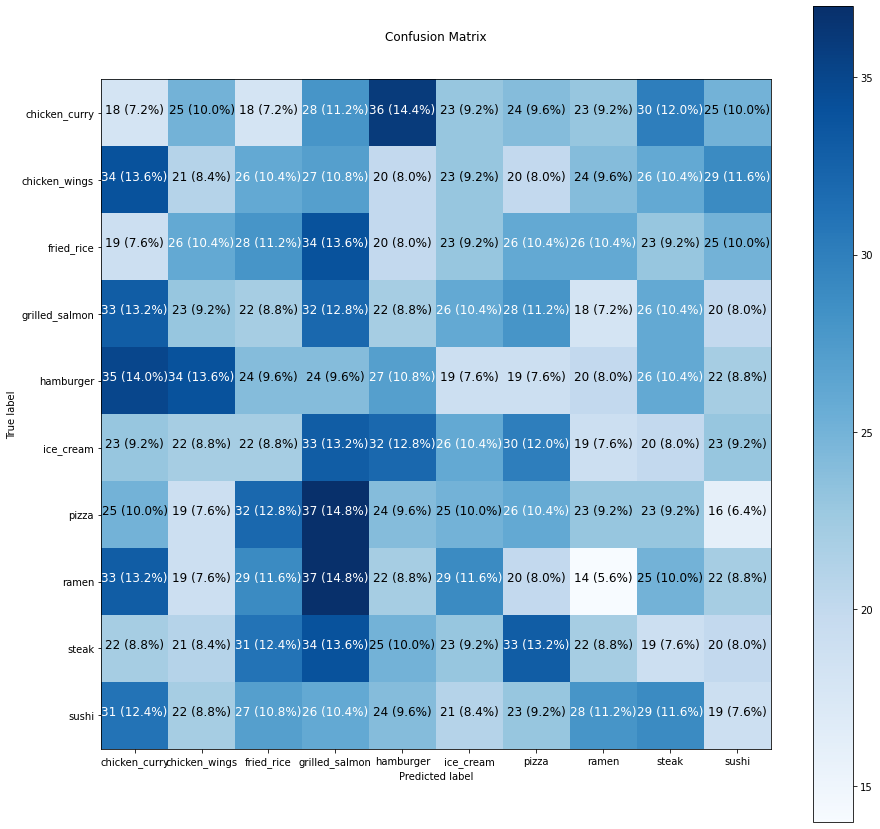

In [44]:
make_confusion_matrix(true_classes, predicted_classes, class_labels)

## Prediction

In [45]:
img,test_labels=test_data.next()

In [46]:
test_labels

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 

In [47]:
class_labels

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [48]:
!wget https://github.com/ackermanjayjay/food-classification/raw/main/data_untuk_workhsop.zip

--2022-09-05 12:39:23--  https://github.com/ackermanjayjay/food-classification/raw/main/data_untuk_workhsop.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ackermanjayjay/food-classification/main/data_untuk_workhsop.zip [following]
--2022-09-05 12:39:24--  https://raw.githubusercontent.com/ackermanjayjay/food-classification/main/data_untuk_workhsop.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99578617 (95M) [application/zip]
Saving to: ‘data_untuk_workhsop.zip’

data_untuk_workhsop 100%[===================>]  94.96M   371MB/s    in 0.3s    

2022-09-05 12:39:24 (371 MB/s) - ‘data_untu

In [49]:
!unzip data_untuk_workhsop.zip

Archive:  data_untuk_workhsop.zip
   creating: val/
   creating: val/fried_rice/
  inflating: val/fried_rice/3515250.jpg  
  inflating: val/fried_rice/3521139.jpg  
  inflating: val/fried_rice/3528567.jpg  
  inflating: val/fried_rice/3531198.jpg  
  inflating: val/fried_rice/3542359.jpg  
  inflating: val/fried_rice/3547337.jpg  
  inflating: val/fried_rice/3554481.jpg  
  inflating: val/fried_rice/3555295.jpg  
  inflating: val/fried_rice/3571082.jpg  
  inflating: val/fried_rice/3584356.jpg  
  inflating: val/fried_rice/3586562.jpg  
  inflating: val/fried_rice/3588023.jpg  
  inflating: val/fried_rice/3592807.jpg  
  inflating: val/fried_rice/3603260.jpg  
  inflating: val/fried_rice/3607245.jpg  
  inflating: val/fried_rice/3607348.jpg  
  inflating: val/fried_rice/3618827.jpg  
  inflating: val/fried_rice/3619973.jpg  
  inflating: val/fried_rice/3620105.jpg  
  inflating: val/fried_rice/3623708.jpg  
  inflating: val/fried_rice/3627295.jpg  
  inflating: val/fried_rice/3628597.j

In [50]:
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)


  # Decode the read file into a tensor & ensure 3 colour channels 
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)
  

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [51]:
pred=load_and_prep_image("train/ice_cream/995526.jpg")

In [52]:
pred=mobileNet_model.predict(tf.expand_dims(pred,axis=0))

In [53]:
pred.argmax()

5

In [54]:
class_labels[pred.argmax()]

'ice_cream'

In [55]:
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
    print(f" pred is : {pred_class}")
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

 pred is : ice_cream


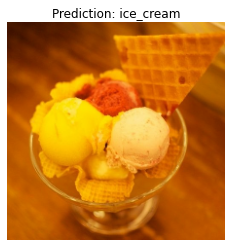

In [56]:
pred_and_plot(mobileNet_model,"train/ice_cream/995526.jpg",class_labels)

# Number 2

1. convnext_xlarge_21k_1k_384_fe 
2. imagenet
3. progan128

# Number 3

In [57]:
!mv test image
!mv train image
!mv val image

In [58]:
data_dir="image"

In [59]:
for dirpath, dirnames, filenames in os.walk(data_dir):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 4 directories and 0 images in 'image'.
There are 0 directories and 100 images in 'image/fried_rice'.
There are 0 directories and 100 images in 'image/ice_cream'.
There are 2 directories and 0 images in 'image/val'.
There are 0 directories and 100 images in 'image/val/fried_rice'.
There are 0 directories and 100 images in 'image/val/ice_cream'.
There are 2 directories and 0 images in 'image/train'.
There are 0 directories and 800 images in 'image/train/fried_rice'.
There are 0 directories and 800 images in 'image/train/ice_cream'.


In [60]:
IMAGE_SHAPE

(224, 224)

In [61]:
train_dir="image/train"
val_dir="image/val"

In [130]:
train_datagen = ImageDataGenerator(rescale = 1/255.)
val_datagen = ImageDataGenerator(rescale = 1/255.)

In [131]:
train_data = train_datagen.flow_from_directory(train_dir,
                                          batch_size = 32 , 
                                          target_size =IMAGE_SHAPE, 
                                          class_mode = 'binary', 
                                             )
val_data = val_datagen.flow_from_directory(val_dir,
                                        batch_size = 32 , 
                                        target_size =IMAGE_SHAPE, 
                                        class_mode = 'binary', )

Found 1600 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [132]:
train_data.class_indices

{'fried_rice': 0, 'ice_cream': 1}

In [133]:
# Function ImageData Generator
def plot_dataGenerator(data):
  x , y  = data.next()
  for i in range(2):
    image = x[i]
    label = y[i]
    plt.axis(False)
    # print(label) --> for checking whether it's plotting right ones
    if label == 1.0:
      label = 'ice_cream'
    else:
      label = 'fried_rice'
    plt.title(label)
    plt.imshow(image)
    plt.show()

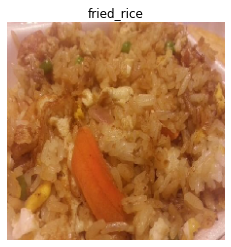

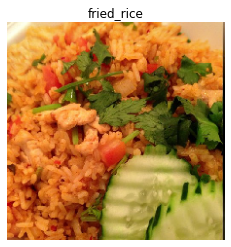

In [134]:
plot_dataGenerator(val_data)

In [135]:
custom_data_model = tf.keras.Sequential([
  mobileNet_model,
  layers.Dense(1 , activation= 'sigmoid' , name ='output_layer')                             
])

# Printing the summarr of the model 
custom_data_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 10)                2270794   
                                                                 
 output_layer (Dense)        (None, 1)                 11        
                                                                 
Total params: 2,270,805
Trainable params: 12,821
Non-trainable params: 2,257,984
_________________________________________________________________


In [136]:
custom_data_model.compile(loss = tf.keras.losses.BinaryCrossentropy() , 
                          optimizer = Adam(learning_rate= 0.001) , 
                          metrics = ['accuracy'])

In [137]:
custom_model_history = custom_data_model.fit(train_data,
                                  epochs=15,
                                  steps_per_epoch=len(train_data),
                                  validation_data=val_data,
                                  validation_steps=len(val_data), )

Epoch 1/15
50/50 [==============================] - 10s 180ms/step - loss: 0.6814 - accuracy: 0.5000 - val_loss: 0.6674 - val_accuracy: 0.5000
Epoch 2/15
50/50 [==============================] - 8s 167ms/step - loss: 0.6525 - accuracy: 0.5000 - val_loss: 0.6396 - val_accuracy: 0.5000
Epoch 3/15
50/50 [==============================] - 8s 168ms/step - loss: 0.5245 - accuracy: 0.7700 - val_loss: 0.4314 - val_accuracy: 0.9800
Epoch 4/15
50/50 [==============================] - 8s 169ms/step - loss: 0.4120 - accuracy: 0.9931 - val_loss: 0.4048 - val_accuracy: 0.9900
Epoch 5/15
50/50 [==============================] - 8s 169ms/step - loss: 0.3889 - accuracy: 0.9969 - val_loss: 0.3840 - val_accuracy: 0.9950
Epoch 6/15
50/50 [==============================] - 8s 167ms/step - loss: 0.3708 - accuracy: 0.9975 - val_loss: 0.3680 - val_accuracy: 0.9950
Epoch 7/15
50/50 [==============================] - 10s 204ms/step - loss: 0.3545 - accuracy: 0.9975 - val_loss: 0.3534 - val_accuracy: 0.9950
Epoc

## Evaluation

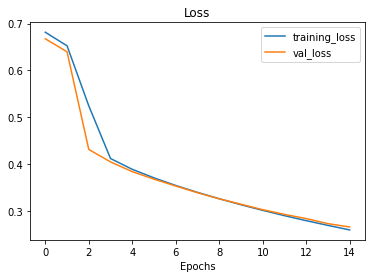

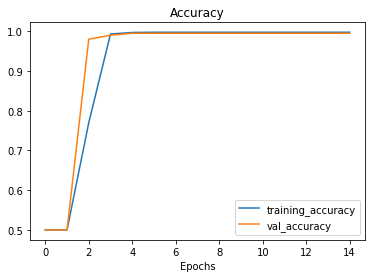

In [138]:
plot_loss_curves(custom_model_history)

In [143]:
STEP_SIZE_TEST=val_data.n//val_data.batch_size
val_data.reset()
preds = custom_data_model.predict(val_data,
verbose=1)

7/7 [==============================] - 1s 130ms/step


In [145]:
from sklearn.metrics import (roc_curve,auc)

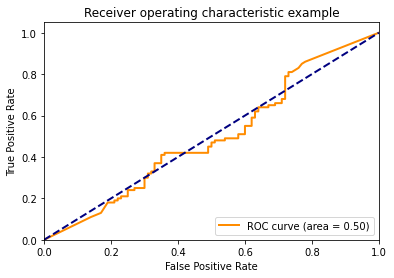

In [147]:
fpr, tpr, _ = roc_curve(val_data.classes, preds)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
